## Effect of survey designs

This notebook uses different sampling strategies to generate image counts.

It uses

- standard sampling as in the main results
- random sampling
- a spiral design




In [1]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
from math import *
from tqdm import tqdm
import pandas as pd
from scipy import interpolate

In [2]:
p=0.2 # single coverage with p=0.2
Nr = 10 # n repeats

  0%|          | 0/10 [00:00<?, ?it/s]

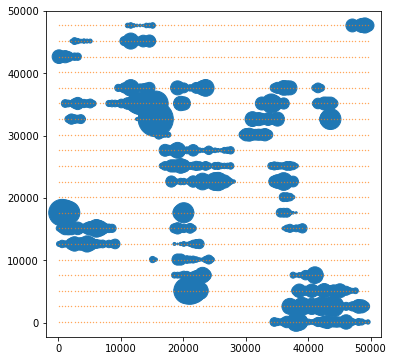

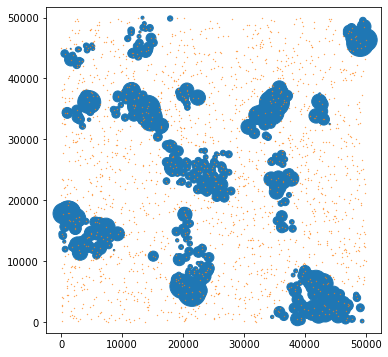

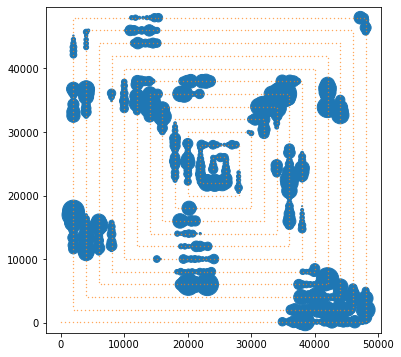

 10%|█         | 1/10 [03:04<27:42, 184.77s/it]

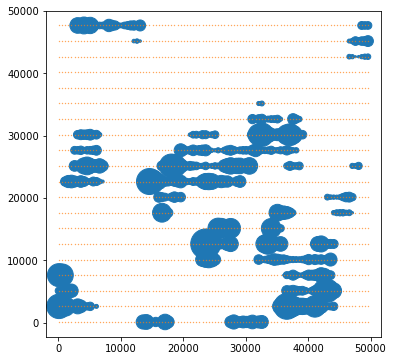

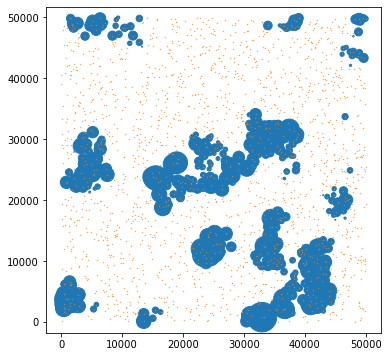

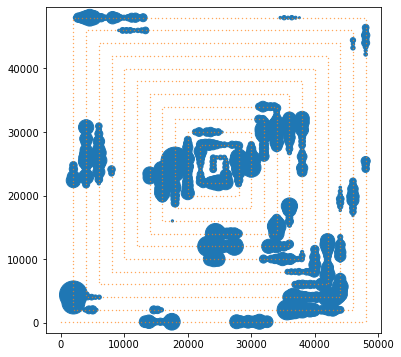

 20%|██        | 2/10 [05:56<23:38, 177.36s/it]

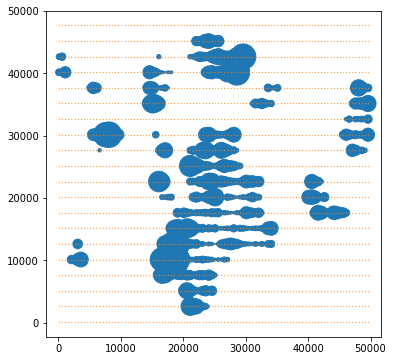

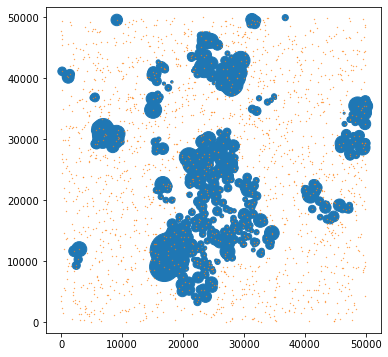

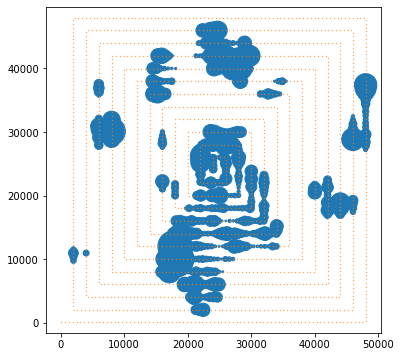

 30%|███       | 3/10 [08:21<18:55, 162.23s/it]

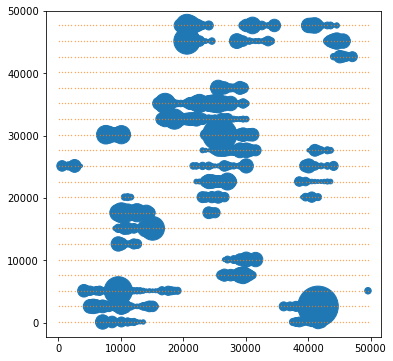

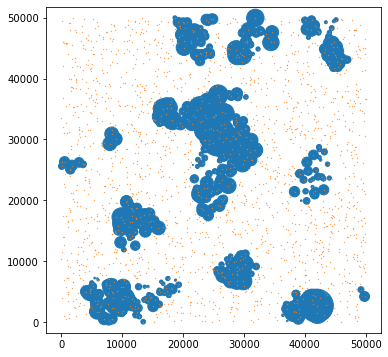

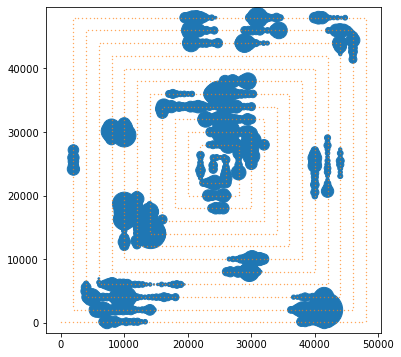

 40%|████      | 4/10 [10:38<15:15, 152.55s/it]

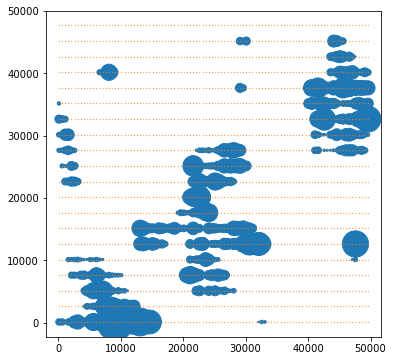

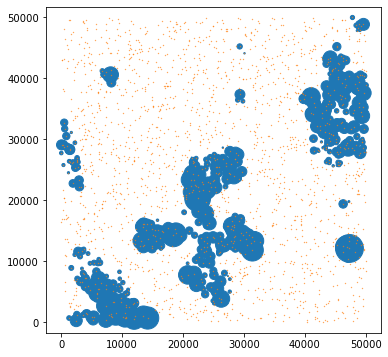

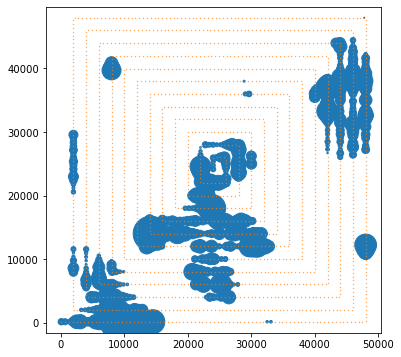

 50%|█████     | 5/10 [12:50<12:04, 144.86s/it]

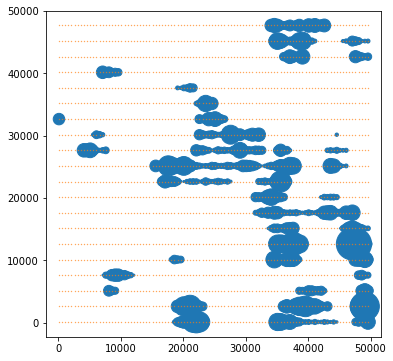

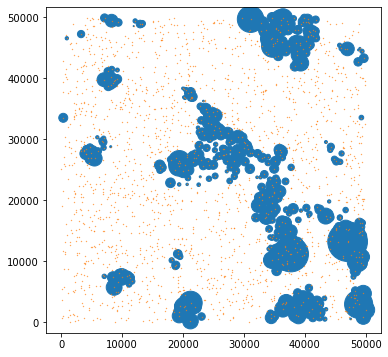

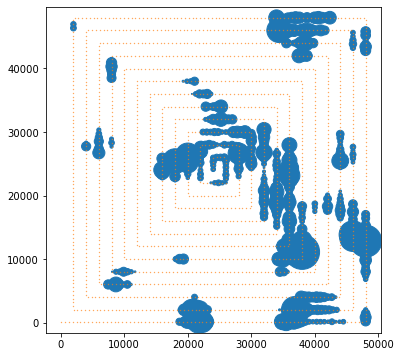

 60%|██████    | 6/10 [15:07<09:29, 142.42s/it]

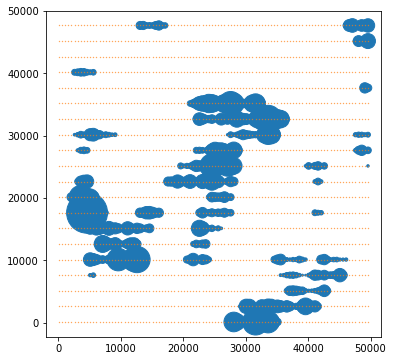

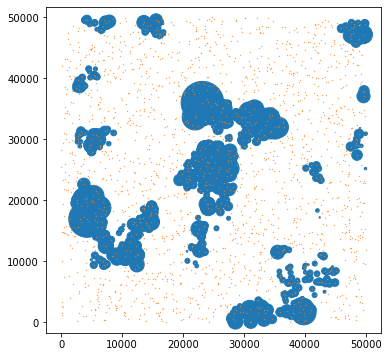

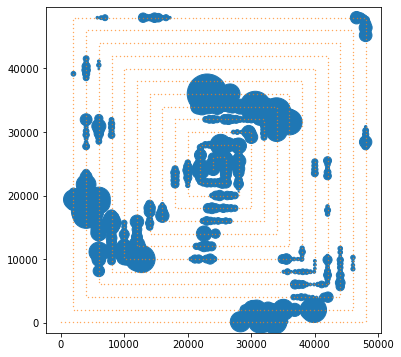

 70%|███████   | 7/10 [17:26<07:03, 141.15s/it]

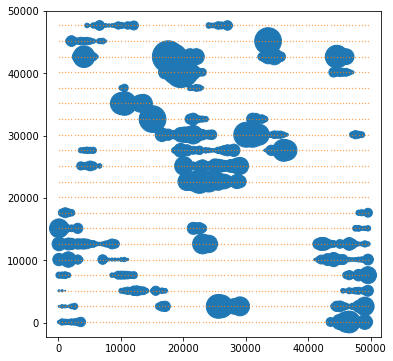

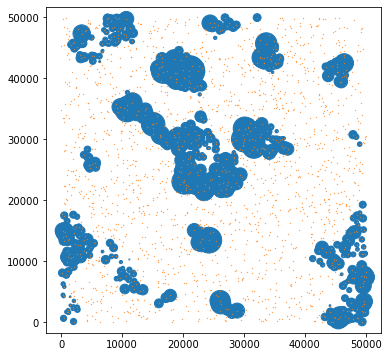

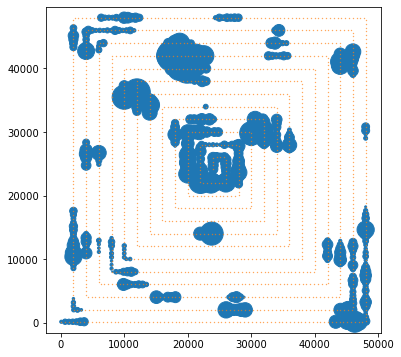

 80%|████████  | 8/10 [19:41<04:38, 139.12s/it]

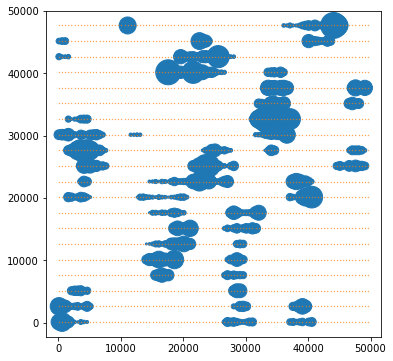

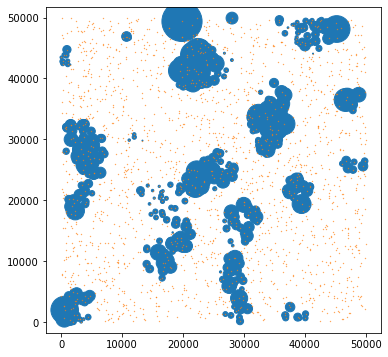

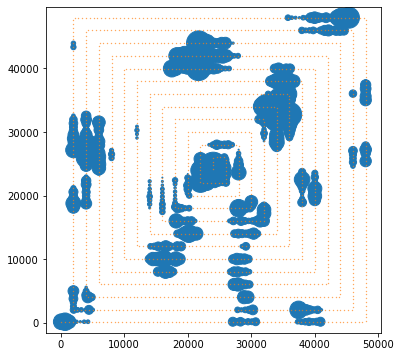

 90%|█████████ | 9/10 [21:55<02:17, 137.64s/it]

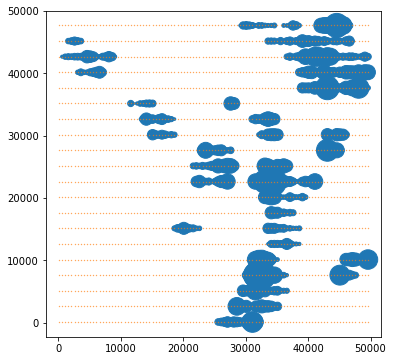

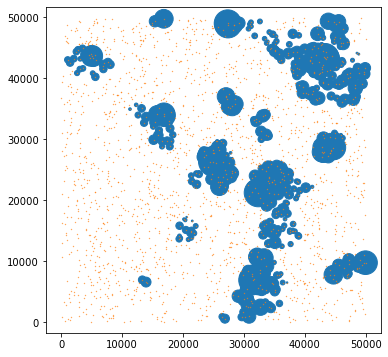

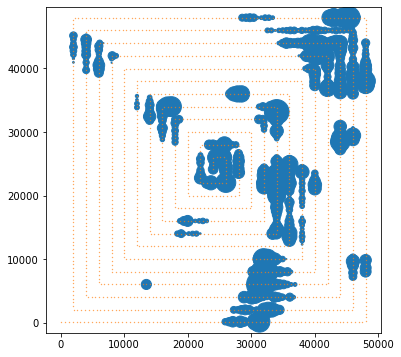

100%|██████████| 10/10 [24:14<00:00, 145.42s/it]


In [4]:
for r in tqdm(range(Nr)):


    ####################################################################################################################################
    ####################################################################################################################################
    ############################################FIRST GENERATE THE SPATIAL FIELD TO SAMPLE FROM#########################################
    ####################################################################################################################################
    ####################################################################################################################################
    
    # make a random field with 2k correlation length
    x = y = np.arange(0,50000,100)
    L = 2000
    var=1.0

    model = gs.Exponential(dim=2, var=var, len_scale=L)
    srf = gs.SRF(model)
    field = srf.structured([x, y])

    # make a 5k presence-absence field
    L = 4000
    var = 1
    model = gs.Gaussian(dim=2, var=var, len_scale=L)
    srf = gs.SRF(model)

    # we make the pa field bigger so we can centre it on the largest cluster of wildebeest
    x2 = y2 = np.arange(-50000,100000,1000)
    pa_field = srf.structured([x2, y2])
    # interpolate as the grid generation is slow for large N
    f = interpolate.interp2d(x2, y2, pa_field, kind='cubic')
    x2 = y2 = np.arange(-50000,100000,100)

    pa_field = f(x2,y2)

    # next we find the highest value of the pa field
    ij = pa_field[500:1000,500:1000].argmax()
    # and centre it so it's at the middle of the survey
    i = ij//500
    j = ij - i*500
    pa_field2 = pa_field[500+i-250:500+i+250,500+j-250:500+j+250]
    # only populate the top p%
    cutoff = np.percentile(pa_field2,100*(1-p))

    # set to negative infinity sets it to zero when we take the exponential
    field[pa_field2<cutoff]=-np.inf

    #set the mean so we end up with roughly 1.3m wildebeest
    target_w = 1300000
    vf = np.var(field[np.isfinite(field)])
    mf = np.mean(field[np.isfinite(field)])
    target_log_density = np.log(target_w/(p*50000*50000))-0.5*vf-mf

    # generate a random count for each grid cell of 100mx100m
    wcounts = np.random.poisson(lam = 100*100*np.exp(target_log_density+field))

    # next place the wildebeest in a random location within their cell
    total = wcounts.sum()
    positions = np.zeros((total,2))

    min_x = 0
    max_x = 50000
    min_y = 0
    max_y = 50000
    w = 0
    for i in (range(len(x))):
        for j in range(len(y)):
            wtotal =  wcounts[i,j]
            positions[w:w+wtotal,0]=x[i]+np.random.uniform(100,size=wtotal) # place at random in the 100x100 cell
            positions[w:w+wtotal,1]=y[j]+np.random.uniform(100,size=wtotal)
            w = w + wtotal

    ####################################################################################################################################
    ####################################################################################################################################
    ####################################################################################################################################
    ####################################################################################################################################
    

    # NEXT FLY THE SURVEYS (WE USE THE SAME DATA FOR EACH DESIGN FOR CONSISTENCY)
            
    # fly the standard survey
    yvals = np.arange(135,max_y,2500)
    
    photos=[]
    transect=0
    for yv in (yvals):

        ymin = yv - 135
        ymax = yv + 135

        xvals = np.arange(90,max_x,500)

        if len(xvals):
            transect+=1

        for xv in xvals:

            # images are 180x270 metres
            xmin = xv - 90
            xmax = xv + 90

            ymin = ymin 
            ymax = ymax 

            count = np.sum((positions[:,0]>xmin)&(positions[:,0]<xmax)&(positions[:,1]>ymin)&(positions[:,1]<ymax))

            photo = [xv,yv,count,transect]
            photos.append(photo)

    photos = np.array(photos)  

    plt.figure(figsize=(6,6))
    plt.scatter(photos[:,0],photos[:,1],s=photos[:,2])

    plt.scatter(photos[:,0],photos[:,1],s=0.1)

    plt.axis('equal')
    plt.show()
    # save the data
    outputfile = 'simdata/sampledata_standard_p' + str(p*10) + '_r' + str(r) + '.csv'
    f = open(outputfile,'w')
    f.write("x,y,wildebeest,transect_id,photo_area\n")

    x_str = '%.2f,' % 0
    y_str = '%.2f,' % 0
    w_str = '%d,' % total
    t_str = '%d,' % -1
    a_str = '%d' % 0
    f.write(x_str + y_str + w_str + t_str + a_str )
    f.write('\n')
    for photo in photos:
        x_str = '%.2f,' % (photo[0]/1)
        y_str = '%.2f,' % (photo[1]/1)
        w_str = '%d,' % photo[2]
        t_str = '%d,' % photo[3]
        a_str = '%.6f' % (180*270/1/1)
        f.write(x_str + y_str + w_str + t_str + a_str )
        f.write('\n')
    f.close()
    
    # fly the random survey
    nphoto=2000
    xyvals = np.random.uniform(low=[min_x,min_y],high=[max_x,max_y],size=(nphoto,2))
    photos=[]
    transect=0
    
    for i in range(nphoto):
        xv = xyvals[i][0]
        yv = xyvals[i][1]
        ymin = yv - 135
        ymax = yv + 135

        transect+=1

        
        # images are 180x270 metres
        xmin = xv - 90
        xmax = xv + 90

        ymin = ymin 
        ymax = ymax 

        count = np.sum((positions[:,0]>xmin)&(positions[:,0]<xmax)&(positions[:,1]>ymin)&(positions[:,1]<ymax))

        photo = [xv,yv,count,transect]
        photos.append(photo)

    photos = np.array(photos)  

    plt.figure(figsize=(6,6))
    plt.scatter(photos[:,0],photos[:,1],s=photos[:,2])

    plt.scatter(photos[:,0],photos[:,1],s=0.1)

    plt.axis('equal')
    plt.show()
    # save the data
    outputfile = 'simdata/sampledata_random_p' + str(p*10) + '_r' + str(r) + '.csv'
    f = open(outputfile,'w')
    f.write("x,y,wildebeest,transect_id,photo_area\n")

    x_str = '%.2f,' % 0
    y_str = '%.2f,' % 0
    w_str = '%d,' % total
    t_str = '%d,' % -1
    a_str = '%d' % 0
    f.write(x_str + y_str + w_str + t_str + a_str )
    f.write('\n')
    for photo in photos:
        x_str = '%.2f,' % (photo[0]/1)
        y_str = '%.2f,' % (photo[1]/1)
        w_str = '%d,' % photo[2]
        t_str = '%d,' % photo[3]
        a_str = '%.6f' % (180*270/1/1)
        f.write(x_str + y_str + w_str + t_str + a_str )
        f.write('\n')
    f.close()
    
    
    # fly the spiral survey
    start = np.array([90,135])
    step = 2000
    moves = 10*np.array([[1,0],[0,1],[-1,0],[0,-1]])
    nphoto = 120000# reduce later but to get the spiral lined up right we use higher resolution
    xyvals = np.zeros((nphoto,2))
    xyvals[0] = start

    min_x = 0
    max_x = 50000
    min_y = 0
    max_y = 50000

    right=0
    up=1
    left=2
    down=3

    direction=0
    for i in range(1,nphoto):

        xyvals[i] = xyvals[i-1]+moves[direction]
        next_step=xyvals[i]+moves[direction]

        if (next_step[0]>(max_x-step)) and (direction==right):
            direction+=1
            max_x -= step
        if (next_step[0]<(min_x+step)) and (direction==left):
            direction+=1
            min_x += step
        if (next_step[1]>(max_y-step)) and (direction==up):
            direction+=1
            max_y -= step
        if (next_step[1]<(min_y+step)) and (direction==down):
            direction=0
            min_y += step

    xyvals=xyvals[::60]
    nphoto=2000
    photos=[]
    transect=0
    
    for i in range(nphoto):
        xv = xyvals[i][0]
        yv = xyvals[i][1]
        ymin = yv - 135
        ymax = yv + 135

        transect+=1

        
        # images are 180x270 metres
        xmin = xv - 90
        xmax = xv + 90

        ymin = ymin 
        ymax = ymax 

        count = np.sum((positions[:,0]>xmin)&(positions[:,0]<xmax)&(positions[:,1]>ymin)&(positions[:,1]<ymax))

        photo = [xv,yv,count,transect]
        photos.append(photo)

    photos = np.array(photos)  

    plt.figure(figsize=(6,6))
    plt.scatter(photos[:,0],photos[:,1],s=photos[:,2])

    plt.scatter(photos[:,0],photos[:,1],s=0.1)

    plt.axis('equal')
    plt.show()
    # save the data
    outputfile = 'simdata/sampledata_spiral_p' + str(p*10) + '_r' + str(r) + '.csv'
    f = open(outputfile,'w')
    f.write("x,y,wildebeest,transect_id,photo_area\n")

    x_str = '%.2f,' % 0
    y_str = '%.2f,' % 0
    w_str = '%d,' % total
    t_str = '%d,' % -1
    a_str = '%d' % 0
    f.write(x_str + y_str + w_str + t_str + a_str )
    f.write('\n')
    for photo in photos:
        x_str = '%.2f,' % (photo[0]/1)
        y_str = '%.2f,' % (photo[1]/1)
        w_str = '%d,' % photo[2]
        t_str = '%d,' % photo[3]
        a_str = '%.6f' % (180*270/1/1)
        f.write(x_str + y_str + w_str + t_str + a_str )
        f.write('\n')
    f.close()
    #break
#break

    #break
#break
